# Map Trove newspaper results by state

Version 2 of the Trove API adds the `state` facet to the `newspapers` zone. This means we can easily get the number of articles from a search query published in each state.

<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!.</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them. When you hover over them a <i class="fa-step-forward fa"></i> icon appears.</li>
        <li>To run a code cell either click the <i class="fa-step-forward fa"></i> icon, or click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>
</div>

## Add your API key

In [1]:
# This creates a variable called 'api_key', paste your key between the quotes
# <-- Then click the run icon 
api_key = '6pi5hht0d2umqcro'

# This displays a message with your key
print('Your API key is: {}'.format(api_key))

Your API key is: 6pi5hht0d2umqcro


## Setting things up

You don't need to edit anything here. Just run the cells to load the bits and pieces we need.

In [2]:
# Import the libraries we need
# <-- Click the run icon 
import requests
import pandas as pd
import os
import altair as alt
import json
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
# Set up default parameters for our API query
# <-- Click the run icon 
params = {
    'zone': 'newspaper',
    'encoding': 'json',
    'facet': 'state',
    'n': '1',
    'key': api_key
}

api_url = 'http://api.trove.nla.gov.au/v2/result'

## Construct your search

This is where you set your search keywords. Change 'weather' in the cell below to anything you might enter in the Trove simple search box. For example:

`params['q'] = 'weather AND wragge'`

`params['q'] = '"Clement Wragge"'`

`params['q'] = 'text:"White Australia Policy"'`

`params['q'] = 'weather AND date:[1890-01-01T00:00:00Z TO 1920-12-11T00:00:00Z]'`

You can also limit the results to specific categories. To only search for articles, include this line:

`params['l-category'] = 'Article'`

In [4]:
# Enter your search parameters
# This can be anything you'd enter in the Trove simple search box
params['q'] = 'weather AND wragge date:[* TO 1954]'

# Remove the "#" symbol from the line below to limit the results to the article category
#params['l-category'] = 'Article'

## Get the data from Trove

Everything's set up, so just run the cells!

### Make an API request

In [5]:
# <-- Click the run icon 
response = requests.get(api_url, params=params)
data = response.json()

### Reformat the results

In [6]:
# <-- Click the run icon 
def format_facets(data):
    facets = data['response']['zone'][0]['facets']['facet']['term']
    df = pd.DataFrame(facets)
    df = df[['display', 'count']]
    df.columns = ['state', 'total']
    df['total'] = pd.to_numeric(df['total'], errors='coerce')
    df = df.replace('ACT', 'Australian Capital Territory')
    df = df[(df['state'] != 'National') & (df['state'] != 'International')]
    return df
df = format_facets(data)
df

state  total
0               New South Wales  18243
1                    Queensland  17863
2                      Tasmania   8236
3                      Victoria   5734
4               South Australia   4155
5             Western Australia   1845
6            Northern Territory     47
7  Australian Capital Territory      5

## Make some charts!

Just run the cells!

In [7]:
# Create a bar chart
# <-- Click the run icon 
chart = alt.Chart(df).mark_bar(color='#084081').encode(
    x=alt.X('total', axis=alt.Axis(title='Total articles')),
    y=alt.Y('state', axis=alt.Axis(title='')),
    tooltip=[alt.Tooltip('total', title='Total articles')]
).properties(width=300, height=200)

In [8]:
# Make a chloropleth map
# <-- Click the run icon 
with open('data/aus_state.geojson', "r") as geo_file:
    geo_data = json.load(geo_file)
map = alt.Chart(alt.Data(values=geo_data['features'])
        ).mark_geoshape(stroke='black', strokeWidth=0.2
        ).encode(color=alt.Color('total:Q', scale=alt.Scale(scheme='greenblue'), legend=alt.Legend(title='Total articles'))
        ).transform_lookup(lookup='properties.STATE_NAME', from_=alt.LookupData(df, 'state', ['total'])
        ).project(type='mercator'
        ).properties(width=400, height=400)

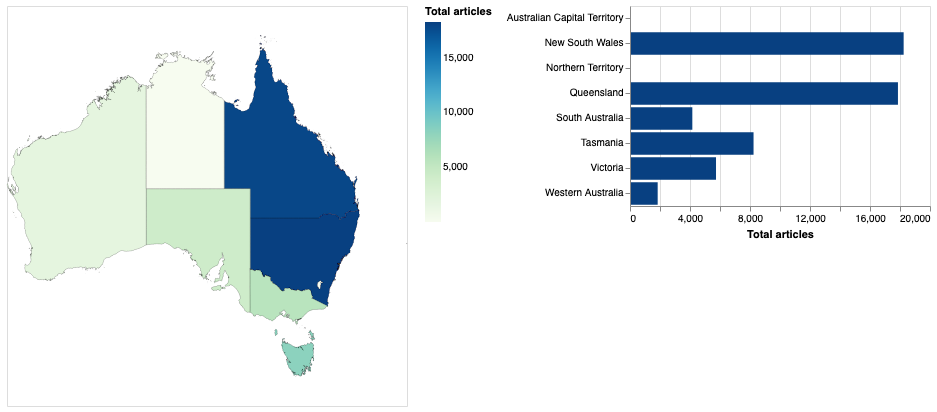

In [9]:
# Display the charts side by side
# <-- Click the run icon 
alt.hconcat(map, chart).resolve_legend(
    color="independent"
)

## Calculate proportions

Of course, this is just the raw number of results. Some states have more newspapers, so we have to be careful about making comparisons. This time we'll divide the number of search results for each state by the total number of articles published in that state to see what proportion our search represents. This should provide a more meaningful basis for comparison.

To calculate what proportion of the total number of articles the search results represent, we need to make another API request to find out how many articles were published over the same time frame. This time we'll leave the keywords out of the query. If you've set a date range, you'll want to keep it as the value for `params['q']`. Otherwise set `params['q']` to a string containing nothing but a space, eg:

```
params['q'] = ' '
```

or

```
params['q'] = 'date:[* TO 1954]'
```

In [10]:
#params['q'] = ' '
params['q'] = 'date:[* TO 1954]'
response = requests.get(api_url, params=params)
total_data = response.json()

In [11]:
# Reformat the facets
total_df = format_facets(total_data)
# Merge the two dataframes, joining them on the 'state' column
df = pd.merge(df, total_df, on='state', how='left')
# Create a new column that contains the proportion of the total results this search represents
df['proportion'] = df['total_x']/df['total_y']
df

state  total_x   total_y  proportion
0               New South Wales    18243  79068471    0.000231
1                    Queensland    17863  40102080    0.000445
2                      Tasmania     8236  15389286    0.000535
3                      Victoria     5734  37580904    0.000153
4               South Australia     4155  24032036    0.000173
5             Western Australia     1845  20202746    0.000091
6            Northern Territory       47    409020    0.000115
7  Australian Capital Territory        5    703244    0.000007

## Make some better charts!

Just run the cells!

In [12]:
# Create a bar chart
# <-- Click the run icon 
chart2 = alt.Chart(df).mark_bar(color='#084081').encode(
    x=alt.X('proportion', axis=alt.Axis(title='Proportion of articles')),
    y=alt.Y('state', axis=alt.Axis(title='')),
    tooltip=[alt.Tooltip('proportion', title='Proportion')]
).properties(width=300, height=200)

In [13]:
map2 = alt.Chart(alt.Data(values=geo_data['features'])
        ).mark_geoshape(stroke='black', strokeWidth=0.2
        ).encode(color=alt.Color('proportion:Q', scale=alt.Scale(scheme='greenblue'), legend=alt.Legend(title='Proportion of articles'))
        ).transform_lookup(lookup='properties.STATE_NAME', from_=alt.LookupData(df, 'state', ['proportion'])
        ).project(type='mercator'
        ).properties(width=400, height=400)

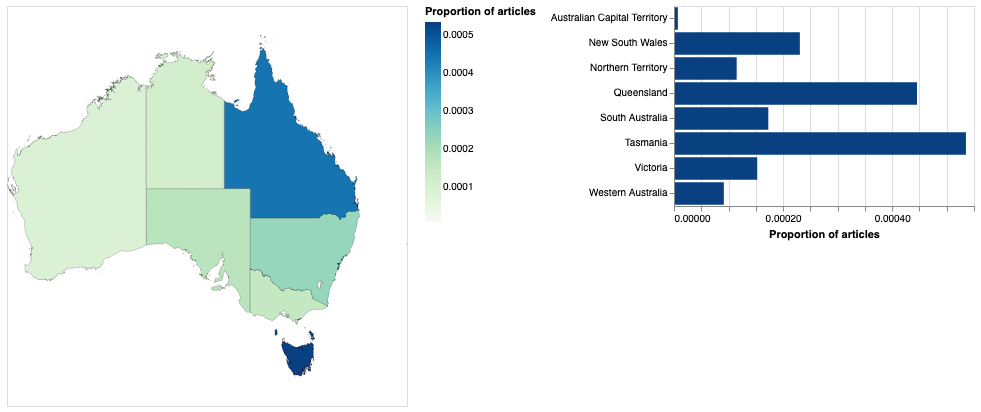

In [14]:
# Display the charts side by side
# <-- Click the run icon 
alt.hconcat(map2, chart2).resolve_legend(
    color="independent"
)